In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline   
import seaborn as sns
import random as random
from tqdm import tqdm
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [16]:
milk_data = pd.read_csv('../Data/TheData.csv')
milk_data['DateTime'] = pd.to_datetime(milk_data['DateTime'], errors='coerce')
milk_data['StartTime'] = pd.to_datetime(milk_data['StartTime'], format='%H:%M:%S', errors='coerce').dt.time
milk_data['StartDate'] = pd.to_datetime(milk_data['StartDate'], errors='coerce')
milk_data.head(3)

,FarmName_Pseudo,SE_Number,AnimalNumber,StartDate,StartTime,LactationNumber,DaysInMilk,TotalYield,DateTime,BreedName,Temperature,Relative Humidity,Precipitation,THI_adj,HW,cum_HW
0,a624fb9a,SE-a624fb9a-1425,1425,2022-04-14,17:53:00,1,42.0,7.68,2022-04-14 17:53:00,01 SRB,4.2,86.8,0.0,40.25016,0,0.0
1,a624fb9a,SE-a624fb9a-1212,1212,2022-04-14,17:45:00,5,192.0,9.58,2022-04-14 17:45:00,02 SLB,4.2,86.8,0.0,40.25016,0,0.0
2,a624fb9a,SE-a624fb9a-1299,1299,2022-04-14,17:54:00,3,138.0,10.94,2022-04-14 17:54:00,01 SRB,4.2,86.8,0.0,40.25016,0,0.0


## Select 1 farm

In [17]:
selected_farm = 'a624fb9a'
selected_farm_data = milk_data[milk_data['FarmName_Pseudo'] == selected_farm]
selected_farm_data = selected_farm_data.copy()
print(f"The daily records dataframe for {selected_farm} (farm) has {selected_farm_data.shape[0]} entries and {selected_farm_data.shape[1]} columns")
selected_farm_data.head(3)

The daily records dataframe for a624fb9a (farm) has 178315 entries and 16 columns


,FarmName_Pseudo,SE_Number,AnimalNumber,StartDate,StartTime,LactationNumber,DaysInMilk,TotalYield,DateTime,BreedName,Temperature,Relative Humidity,Precipitation,THI_adj,HW,cum_HW
0,a624fb9a,SE-a624fb9a-1425,1425,2022-04-14,17:53:00,1,42.0,7.68,2022-04-14 17:53:00,01 SRB,4.2,86.8,0.0,40.25016,0,0.0
1,a624fb9a,SE-a624fb9a-1212,1212,2022-04-14,17:45:00,5,192.0,9.58,2022-04-14 17:45:00,02 SLB,4.2,86.8,0.0,40.25016,0,0.0
2,a624fb9a,SE-a624fb9a-1299,1299,2022-04-14,17:54:00,3,138.0,10.94,2022-04-14 17:54:00,01 SRB,4.2,86.8,0.0,40.25016,0,0.0


### Create the beginning of the dataset

In [18]:
# Ensure that the HW column is binary: 1 for heatwave days, 0 for non-heatwave days
selected_farm_data['HW'] = selected_farm_data['HW'].apply(lambda x: 1 if x > 0 else 0)

# Calculate the DailyTotalYield for each cow each day
selected_farm_data['DailyTotalYield'] = selected_farm_data.groupby(['AnimalNumber', 'StartDate'])['TotalYield'].transform('sum')

# Sort the data by AnimalNumber and StartDate
selected_farm_data.sort_values(['AnimalNumber', 'StartDate'], inplace=True)

# Calculate the previous day's total yield for each cow
selected_farm_data['PreviousDailyTotalYield'] = selected_farm_data.groupby('AnimalNumber')['DailyTotalYield'].shift(1)

# Calculate the daily yield change for each cow
selected_farm_data['DailyYieldChange'] = selected_farm_data['DailyTotalYield'] - selected_farm_data['PreviousDailyTotalYield']


# Filter for nighttime data (22:00 - 07:00)
night_data = selected_farm_data[(selected_farm_data['StartTime'] >= pd.Timestamp('20:00').time()) | 
                                (selected_farm_data['StartTime'] <= pd.Timestamp('08:00').time())]

# Find the minimum temperature for each night
min_night_temp = night_data.groupby('StartDate')['Temperature'].min().reset_index()
min_night_temp.rename(columns={'Temperature': 'MinNightTemp'}, inplace=True)

def categorize_night_temperature(min_temp):
    '''
    Function to classify nights into categories
    '''
    if min_temp > 20:
        return 'Tropical'
    elif 15 < min_temp <= 20:
        return 'Warm'
    elif 5 < min_temp <= 15:
        return 'Ideal'
    elif 0 < min_temp <= 5:
        return 'Mild'
    else:
        return 'Cold'

min_night_temp['NightTempCategory'] = min_night_temp['MinNightTemp'].apply(categorize_night_temperature)


### Get daily records

In [19]:
# Merge the minimum night temperature categories with the main data
selected_farm_data = selected_farm_data.merge(min_night_temp, on='StartDate', how='left')

# Group and aggregate data
grouped_data = selected_farm_data.groupby(['AnimalNumber', 'StartDate']).agg({
    'DailyTotalYield': 'first',
    'PreviousDailyTotalYield': 'first',
    'DailyYieldChange': 'first',
    'HW': 'max',
    'Temperature': 'mean',
    'THI_adj': 'mean',
    'NightTempCategory': 'first',
    'DaysInMilk': 'first'
}).reset_index()

# Renaming and formatting
grouped_data.rename(columns={
    'Temperature': 'MeanTemperature',
    'THI_adj': 'MeanTHI_adj'
}, inplace=True)
grouped_data['Date'] = pd.to_datetime(grouped_data['StartDate'])

# Final DataFrame
new_dataset = grouped_data[['AnimalNumber', 'Date', 'DailyTotalYield', 'DailyYieldChange', 'HW', 'MeanTemperature', 'MeanTHI_adj', 'NightTempCategory', 'DaysInMilk']].copy()
new_dataset.head()

,AnimalNumber,Date,DailyTotalYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,NightTempCategory,DaysInMilk
0,602,2022-01-01,27.16,0.00,0,-2.633333,28.35716,Cold,466.0
1,602,2022-01-02,23.20,-3.96,0,-0.050000,34.35815,Cold,467.0
2,602,2022-01-03,29.42,6.22,0,2.100000,37.07302,Mild,468.0
3,602,2022-01-04,23.09,-6.33,0,-1.150000,31.21318,Cold,469.0
4,602,2022-01-05,21.58,-1.51,0,-4.533333,25.19870,Cold,470.0


Show a lactation curve

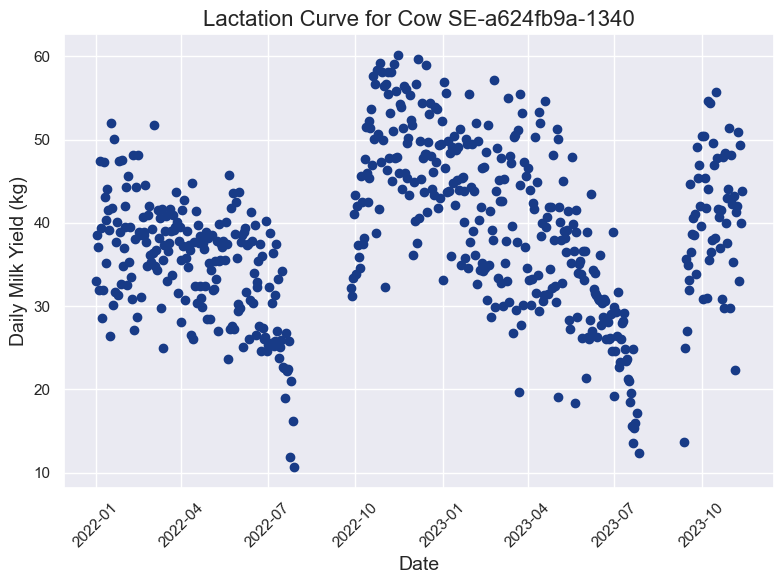

In [20]:
# For demonstration, let's select a random cow from the new_dataset
random_cow = new_dataset['AnimalNumber'].sample().iloc[0]

# Filter data for the selected cow
cow_data = new_dataset[new_dataset['AnimalNumber'] == random_cow] #1297 for a good cow

# Plotting the lactation curve for the selected cow
plt.figure(figsize=(8, 6))
plt.plot(cow_data['Date'], cow_data['DailyTotalYield'], marker='o', linestyle='', color='#183B87')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Milk Yield (kg)', fontsize=14)
plt.title(f'Lactation Curve for Cow SE-{selected_farm}-{random_cow}', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Take away the cows which do not have enough data

In [21]:
# Get the first and last milking date for each cow
milking_dates = new_dataset.groupby('AnimalNumber')['Date'].agg(['min', 'max'])

# Filter out cows with a first milking date around 2022-01-01 and last date around 2023-11-13
# Adjust the dates as needed to define 'approximately'
start_date_cutoff = pd.Timestamp('2022-06-01')
end_date_cutoff = pd.Timestamp('2023-08-13')
selected_cows = milking_dates[(milking_dates['min'] <= start_date_cutoff) & (milking_dates['max'] >= end_date_cutoff)].index

# Filter new_dataset for these selected cows
new_dataset = new_dataset[new_dataset['AnimalNumber'].isin(selected_cows)]

new_dataset.head()

,AnimalNumber,Date,DailyTotalYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,NightTempCategory,DaysInMilk
2242,1199,2022-01-01,36.40,0.00,0,-2.700000,28.468113,Cold,89.0
2243,1199,2022-01-02,56.44,20.04,0,-0.440000,32.385528,Cold,90.0
2244,1199,2022-01-03,35.94,-20.50,0,2.166667,36.816420,Mild,91.0
2245,1199,2022-01-04,49.83,13.89,0,0.375000,31.870470,Cold,92.0
2246,1199,2022-01-05,36.73,-13.10,0,-4.966667,23.238107,Cold,93.0


Try finding any linear correlations between the parameters

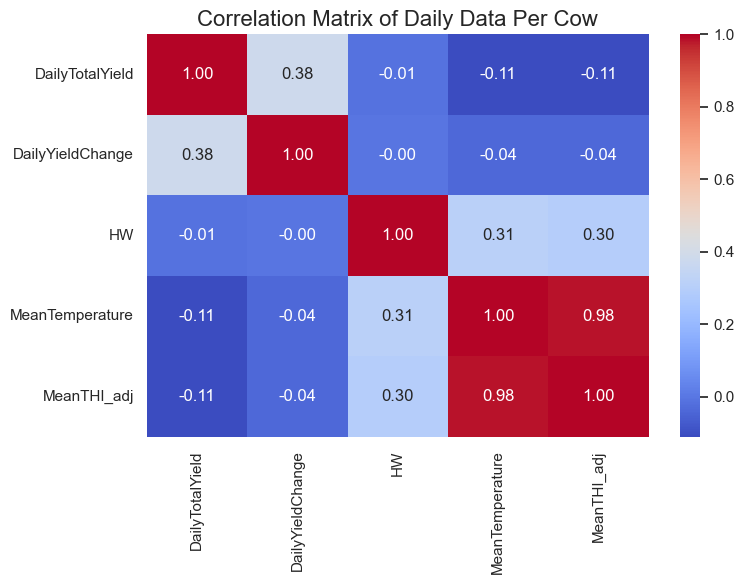

In [22]:
# Compute the correlation matrix for the specified columns
correlation_matrix = new_dataset[['DailyTotalYield', 'DailyYieldChange', 'HW', 'MeanTemperature', 'MeanTHI_adj']].corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set plot title with the specified font size
heatmap.set_title("Correlation Matrix of Daily Data Per Cow", fontsize=16)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

Try to normalize the yields for each cow based on each cow's peak in their lactation curve and then find linear connections

In [23]:
# Find the peak yield for each cow
peak_yield = new_dataset.groupby('AnimalNumber')['DailyTotalYield'].max().reset_index()
peak_yield.rename(columns={'DailyTotalYield': 'PeakYield'}, inplace=True)

# Merge the peak yield back into the dataset
normalized_dataset = new_dataset.merge(peak_yield, on='AnimalNumber')

# Calculate the normalized yield as a percentage of the peak yield
normalized_dataset['NormalizedDailyYield'] = (normalized_dataset['DailyTotalYield'] / normalized_dataset['PeakYield']) * 100

# sort normalized_dataset by AnimalNumber and Date
normalized_dataset.sort_values(['AnimalNumber', 'Date'], inplace=True)

# calc. the normalized daily yield change for each cow
normalized_dataset['NormalizedDailyYieldChange'] = normalized_dataset.groupby('AnimalNumber')['NormalizedDailyYield'].diff()

# Remove the first entry for each cow where the NormalizedDailyYieldChange would be NaN
normalized_dataset = normalized_dataset.dropna(subset=['NormalizedDailyYieldChange'])

normalized_dataset.head()

,AnimalNumber,Date,DailyTotalYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,NightTempCategory,DaysInMilk,PeakYield,NormalizedDailyYield,NormalizedDailyYieldChange
1,1199,2022-01-02,56.44,20.04,0,-0.440000,32.385528,Cold,90.0,62.59,90.174149,32.017894
2,1199,2022-01-03,35.94,-20.50,0,2.166667,36.816420,Mild,91.0,62.59,57.421313,-32.752836
3,1199,2022-01-04,49.83,13.89,0,0.375000,31.870470,Cold,92.0,62.59,79.613357,22.192043
4,1199,2022-01-05,36.73,-13.10,0,-4.966667,23.238107,Cold,93.0,62.59,58.683496,-20.929861
5,1199,2022-01-06,45.57,8.84,0,-8.125000,20.961895,Cold,94.0,62.59,72.807158,14.123662


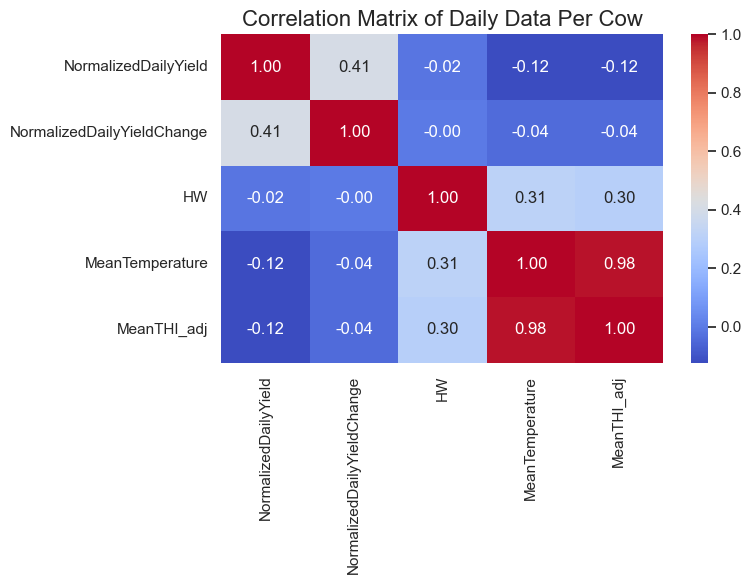

In [24]:
# Compute the correlation matrix for the specified columns
correlation_matrix = normalized_dataset[['NormalizedDailyYield', 'NormalizedDailyYieldChange', 'HW', 'MeanTemperature', 'MeanTHI_adj']].corr()

# PLot the correlations
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
heatmap.set_title("Correlation Matrix of Daily Data Per Cow", fontsize=16)
plt.tight_layout()
plt.show()

## Wood's Lactation Curve
$$
Y(t) = at^be^{-ct}
$$
- $Y(t)$ yield at time $t$ post-calving
- $a$ correlates with the initial production level post-calving
- $b$ governs the incline rate of milk production
- $c$ dictates the decline rate after the peak production 


Normalize the dataset using Wood's lactattion curve and set thresholds for some outliers which have unreasonable values.

In [25]:

# Define the Wood's Lactation Curve function
def woods_lactation_curve(dim, a, b, c):
    dim = np.array(dim, dtype=float)
    return a * dim**b * np.exp(-c * dim)

# Function to fit the Wood's Lactation Curve to the dataset
def fit_woods_lactation_curve(dataset):
    # Initialize the 'ExpectedYield' column to NaN
    dataset['ExpectedYield'] = np.nan
    
    # Group the dataset by 'AnimalNumber' and fit the curve for each cow
    for animal_number, group in tqdm(dataset.groupby('AnimalNumber'), unit=" Cows"):
        # Prepare the data for fitting
        x_data = group['DaysInMilk']
        y_data = group['DailyTotalYield']
        
        # Fit the model
        try:
            # Initial parameter guesses
            initial_guesses = [max(y_data), 0.4, 0.0001]
            # Bounds on the parameters to prevent overflow
            bounds = ([0, 0, 0], [np.inf, 1, 0.1])
            popt, pcov = curve_fit(
                woods_lactation_curve, x_data, y_data,
                p0=initial_guesses, bounds=bounds, maxfev=10000
            )
            
            # Predict the expected yield using the fitted model
            group['ExpectedYield'] = woods_lactation_curve(group['DaysInMilk'], *popt)
            
            # Normalize the DailyTotalYield
            group['NormalizedDailyTotalYield'] = group['DailyTotalYield'] / group['ExpectedYield']
            
            # Calculate the daily yield change and normalize it
            group['DailyYieldChange'] = group['DailyTotalYield'].diff()
            group['NormalizedDailyYieldChange'] = group['DailyYieldChange'] / group['ExpectedYield']
            
            # Update the dataset with the fitted data
            dataset.loc[group.index, 'ExpectedYield'] = group['ExpectedYield']
            dataset.loc[group.index, 'NormalizedDailyTotalYield'] = group['NormalizedDailyTotalYield']
            dataset.loc[group.index, 'NormalizedDailyYieldChange'] = group['NormalizedDailyYieldChange']
            
        except RuntimeError as e:
            print(f"Curve fit failed for cow {animal_number}: {e}")
    
    # Fill any NaN values in the newly created columns with 0
    dataset['ExpectedYield'].fillna(0, inplace=True)
    dataset['NormalizedDailyTotalYield'].fillna(0, inplace=True)
    dataset['NormalizedDailyYieldChange'].fillna(0, inplace=True)
    
    return dataset

# Apply the curve fitting function to your dataset
normalized_yields = fit_woods_lactation_curve(new_dataset)
normalized_yields.head()

100%|██████████| 73/73 [00:03<00:00, 19.30 Cows/s]


,AnimalNumber,Date,DailyTotalYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,NightTempCategory,DaysInMilk,ExpectedYield,NormalizedDailyTotalYield,NormalizedDailyYieldChange
2242,1199,2022-01-01,36.40,0.00,0,-2.700000,28.468113,Cold,89.0,43.364191,0.839402,0.000000
2243,1199,2022-01-02,56.44,20.04,0,-0.440000,32.385528,Cold,90.0,43.329354,1.302581,0.462504
2244,1199,2022-01-03,35.94,-20.50,0,2.166667,36.816420,Mild,91.0,43.293389,0.830150,-0.473513
2245,1199,2022-01-04,49.83,13.89,0,0.375000,31.870470,Cold,92.0,43.256323,1.151970,0.321109
2246,1199,2022-01-05,36.73,-13.10,0,-4.966667,23.238107,Cold,93.0,43.218184,0.849874,-0.303113


Try finding some easy linear correlations.

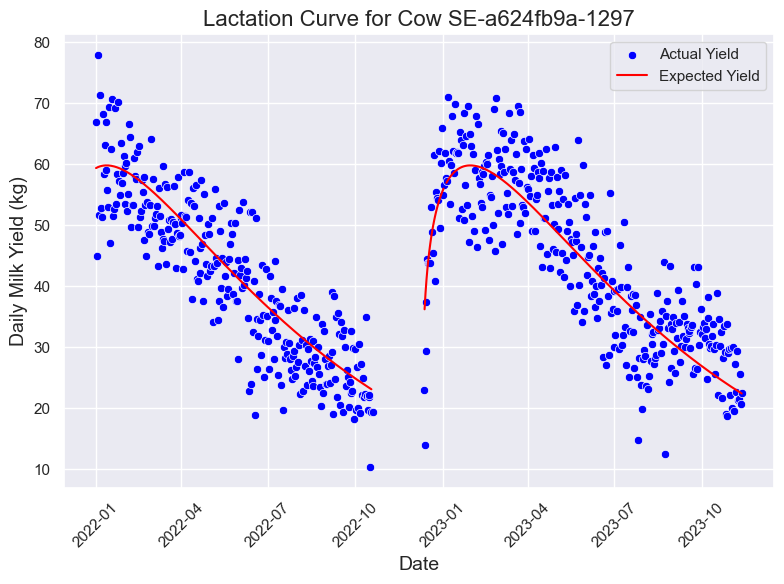

In [26]:
# Plotting the results for cow 1297
cow_1297_data = new_dataset[new_dataset['AnimalNumber'] == 1297]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Date', y='DailyTotalYield', data=cow_1297_data, color='blue', label='Actual Yield')

# Ensure that we only plot the expected yield for consecutive days
# Start by sorting the data by date
cow_1297_data_sorted = cow_1297_data.sort_values('Date')

# Find the indices where there is a jump in dates
date_diffs = cow_1297_data_sorted['Date'].diff().dt.days > 1
discontinuities = date_diffs[date_diffs].index

# Plot the expected yield in segments, skipping the discontinuities
start_idx = cow_1297_data_sorted.index[0]
for end_idx in discontinuities:
    segment = cow_1297_data_sorted.loc[start_idx:end_idx-1]
    if not segment.empty:
        sns.lineplot(x='Date', y='ExpectedYield', data=segment, color='red', label='Expected Yield' if start_idx == cow_1297_data_sorted.index[0] else "")
    start_idx = end_idx + 1
# Don't forget to plot the last segment after the last discont.
last_segment = cow_1297_data_sorted.loc[start_idx:]
if not last_segment.empty:
    sns.lineplot(x='Date', y='ExpectedYield', data=last_segment, color='red', label='Expected Yield' if 'Expected Yield' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Milk Yield (kg)', fontsize=14)
plt.title(f'Lactation Curve for Cow SE-{selected_farm}-{1297}', fontsize=16) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# It seems like the Non-Linear path is the way to go 🚀

In [27]:
# Random Forest model as an example of a non-linear approach
X = normalized_yields[['MeanTemperature', 'MeanTHI_adj']]
y1 = normalized_yields['NormalizedDailyTotalYield']
y2 = normalized_yields['NormalizedDailyYieldChange']

rf_model_totyield = RandomForestRegressor(n_estimators=100) # We used 1000 n_estimators
rf_model_totyield.fit(X, y1)
rf_model_yieldchange = RandomForestRegressor(n_estimators=100) 
rf_model_yieldchange.fit(X, y2)


# Feature importance can indicate which variables are more predictive
print(rf_model_totyield.feature_importances_)

print(rf_model_yieldchange.feature_importances_)

[0.36503531 0.63496469]
[0.37345338 0.62654662]


The figures with the "Normalized Total Daily Yield" on the y-axis shows how changes in average temperature are predicted to impact the normalized total daily yield. The y-axis values represent the magnitude of this impact. For example, a y-value of 1.10 would suggest that at a given temperature, the predicted normalized total daily yield is 10% higher than the baseline (where the baseline is the average or expected yield without considering temperature).

The figures with the "Normalized Yield Change" on the x-axis shows how changes in average temperature are predicted to impact the day-to-day changes in yield. Positive y-axis values indicate an increase in yield change, while negative values indicate a decrease.

<Figure size 800x600 with 0 Axes>

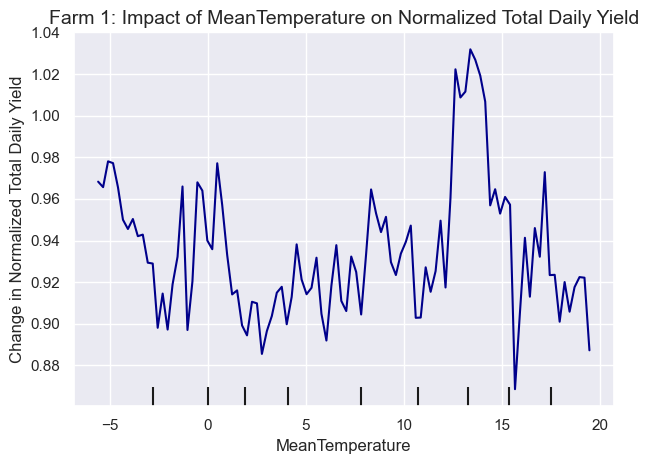

<Figure size 800x600 with 0 Axes>

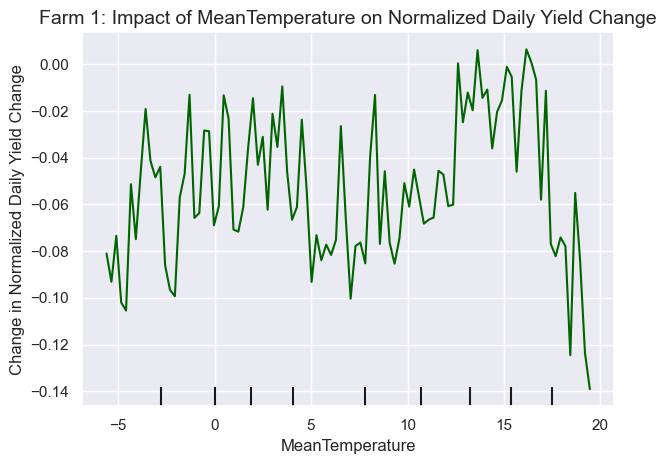

<Figure size 800x600 with 0 Axes>

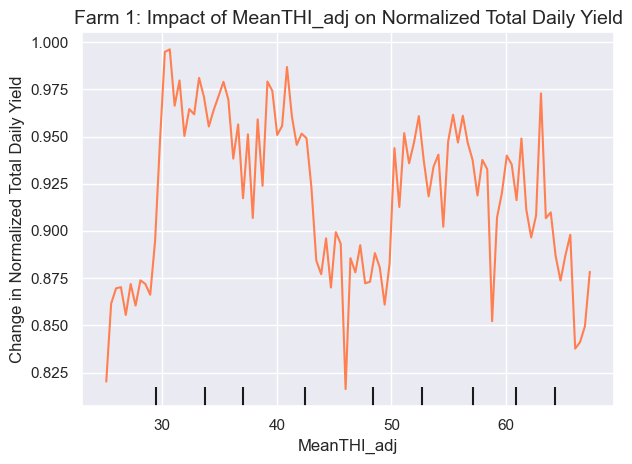

<Figure size 800x600 with 0 Axes>

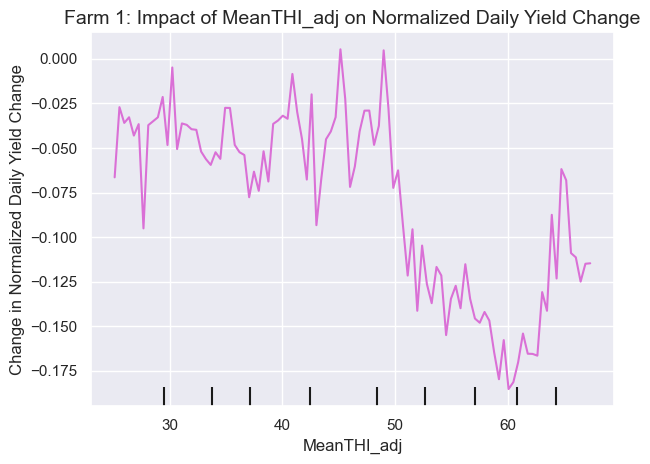

In [28]:
features = ['MeanTemperature', 'MeanTHI_adj']
colors = ['darkblue', 'darkgreen', 'coral', 'orchid']  # list of colors

# gen. partial dependence plots for total yield and yield change
for i, feature in enumerate(features):

    plt.figure(figsize=(8, 6))
    display = PartialDependenceDisplay.from_estimator(
        rf_model_totyield, X, features=[feature],
        line_kw={'color': colors[2*i]}
    )
    display.axes_[0,0].set_title(f'Farm 1: Impact of {feature} on Normalized Total Daily Yield', fontsize=14)
    display.axes_[0,0].set_xlabel(f'{feature}', fontsize=12)
    display.axes_[0,0].set_ylabel('Change in Normalized Total Daily Yield', fontsize=12)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    display = PartialDependenceDisplay.from_estimator(
        rf_model_yieldchange, X, features=[feature],
        line_kw={'color': colors[2*i+1]}  # Use color for the line
    )
    display.axes_[0,0].set_title(f'Farm 1: Impact of {feature} on Normalized Daily Yield Change', fontsize=14)
    display.axes_[0,0].set_xlabel(f'{feature}', fontsize=12)
    display.axes_[0,0].set_ylabel('Change in Normalized Daily Yield Change', fontsize=12)
    plt.tight_layout()
    plt.show()

<Figure size 800x600 with 0 Axes>

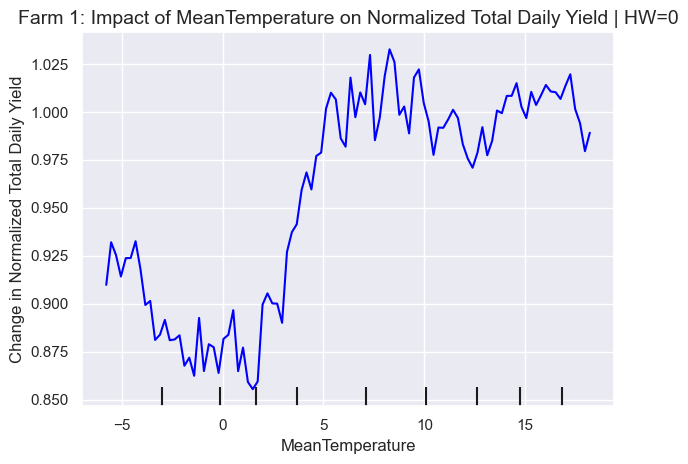

<Figure size 800x600 with 0 Axes>

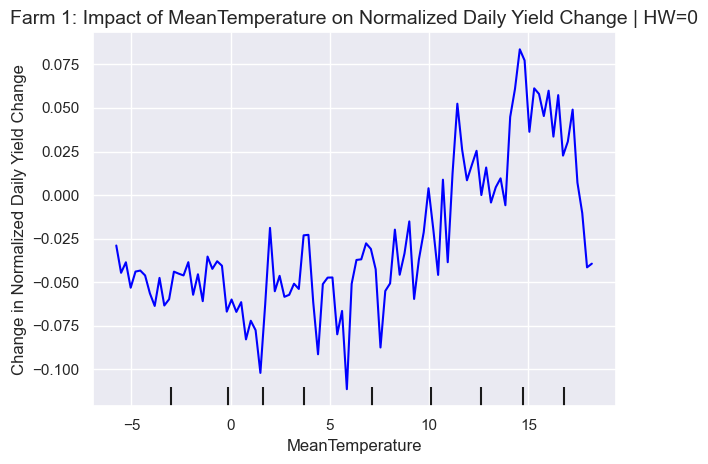

<Figure size 800x600 with 0 Axes>

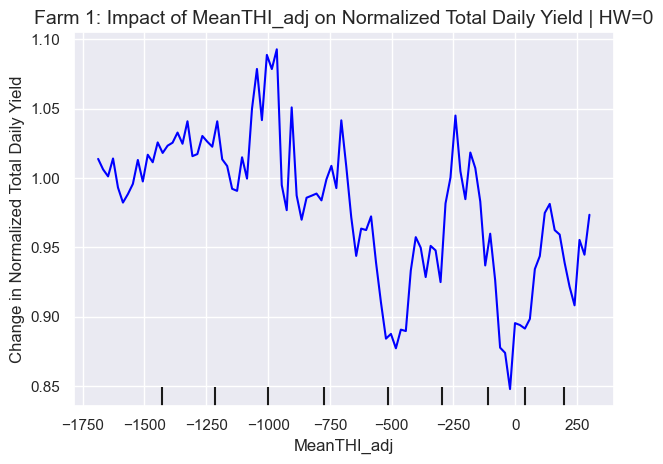

<Figure size 800x600 with 0 Axes>

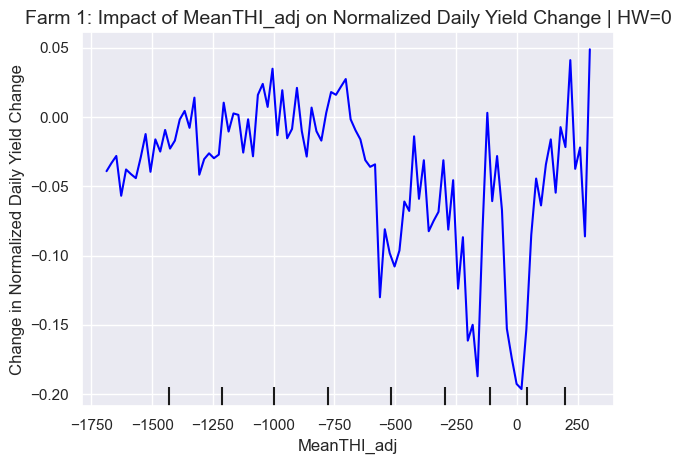

<Figure size 800x600 with 0 Axes>

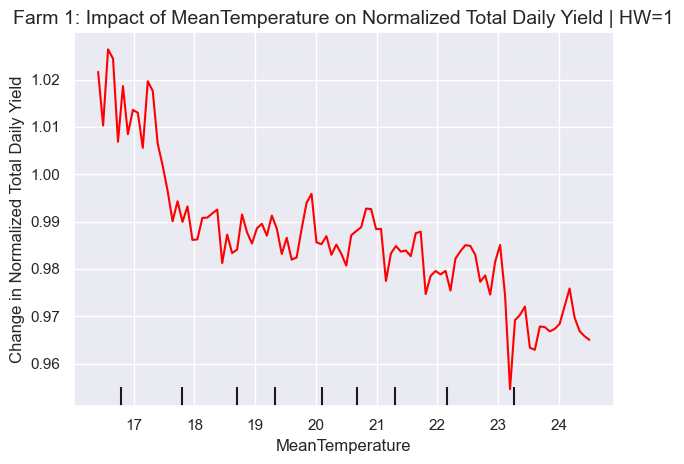

<Figure size 800x600 with 0 Axes>

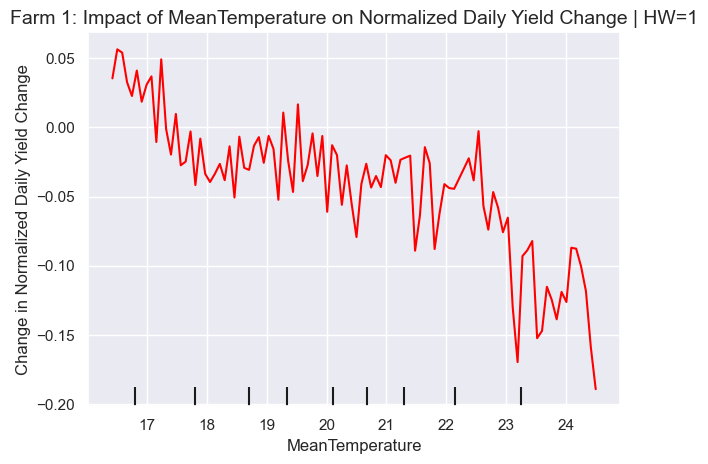

<Figure size 800x600 with 0 Axes>

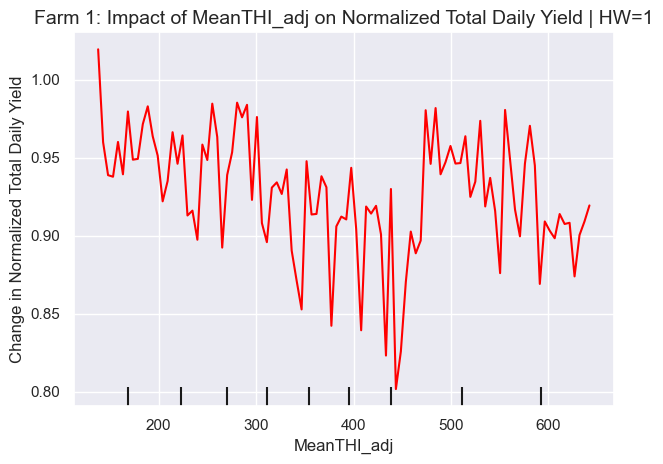

<Figure size 800x600 with 0 Axes>

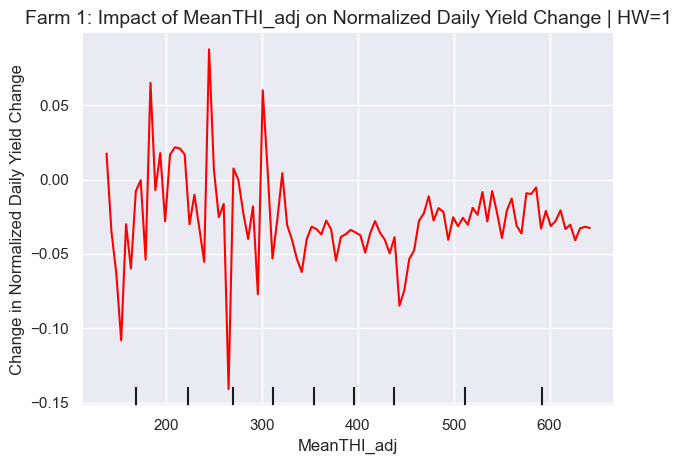

In [16]:
colors = {0: 'blue', 1: 'red'}  #colors for HW=0 and HW=1

# Conditional partial dependence plots for different values of HW for each feature
for j, hw_value in enumerate([0, 1]):  # Assuming HW can be 0 or 1
    for i, feature in enumerate(features):

        plt.figure(figsize=(8, 6))
        X_subset = X[normalized_yields['HW'] == hw_value]
        display = PartialDependenceDisplay.from_estimator(
            rf_model_totyield, X_subset, features=[feature],
            line_kw={'color': colors[hw_value]}
        )
        display.axes_[0,0].set_title(f'Farm 1: Impact of {feature} on Normalized Total Daily Yield | HW={hw_value}', fontsize=14)
        display.axes_[0,0].set_xlabel(f'{feature}', fontsize=12)
        display.axes_[0,0].set_ylabel('Change in Normalized Total Daily Yield', fontsize=12)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        display = PartialDependenceDisplay.from_estimator(
            rf_model_yieldchange, X_subset, features=[feature],
            line_kw={'color': colors[hw_value]}
        )
        display.axes_[0,0].set_title(f'Farm 1: Impact of {feature} on Normalized Daily Yield Change | HW={hw_value}', fontsize=14)
        display.axes_[0,0].set_xlabel(f'{feature}', fontsize=12)
        display.axes_[0,0].set_ylabel('Change in Normalized Daily Yield Change', fontsize=12)
        plt.tight_layout()
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


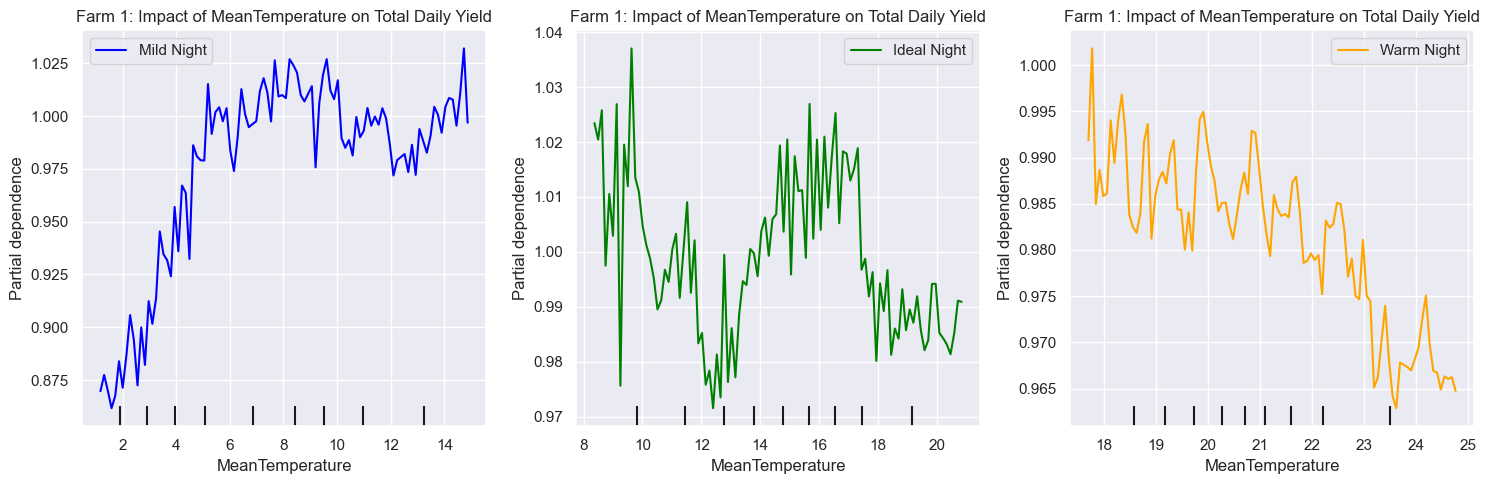

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


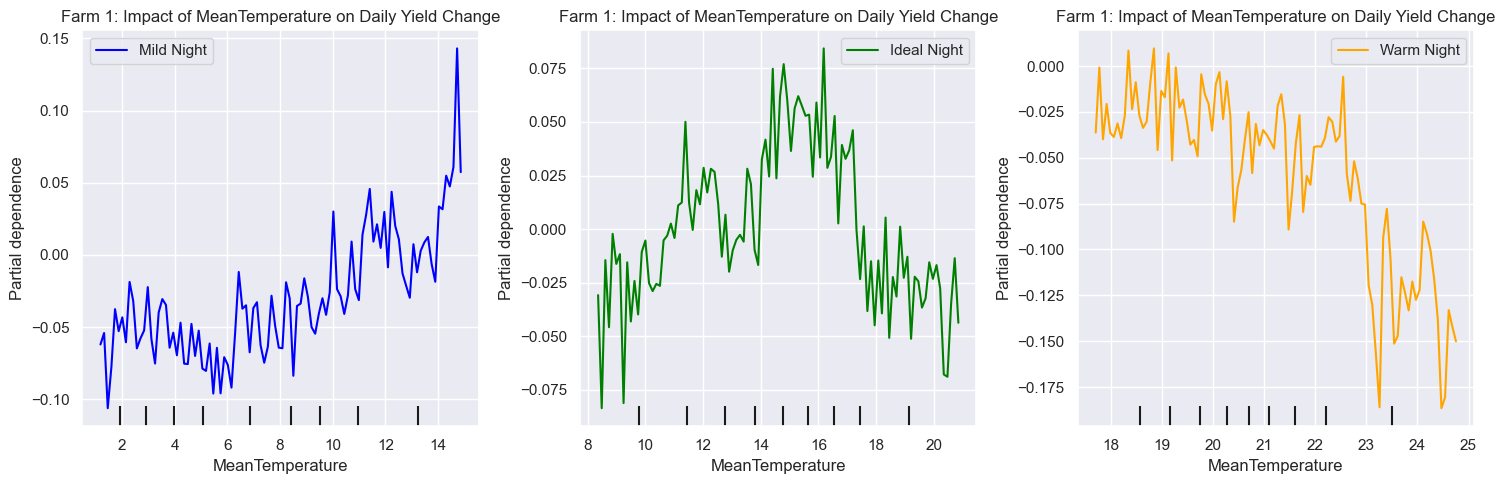

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


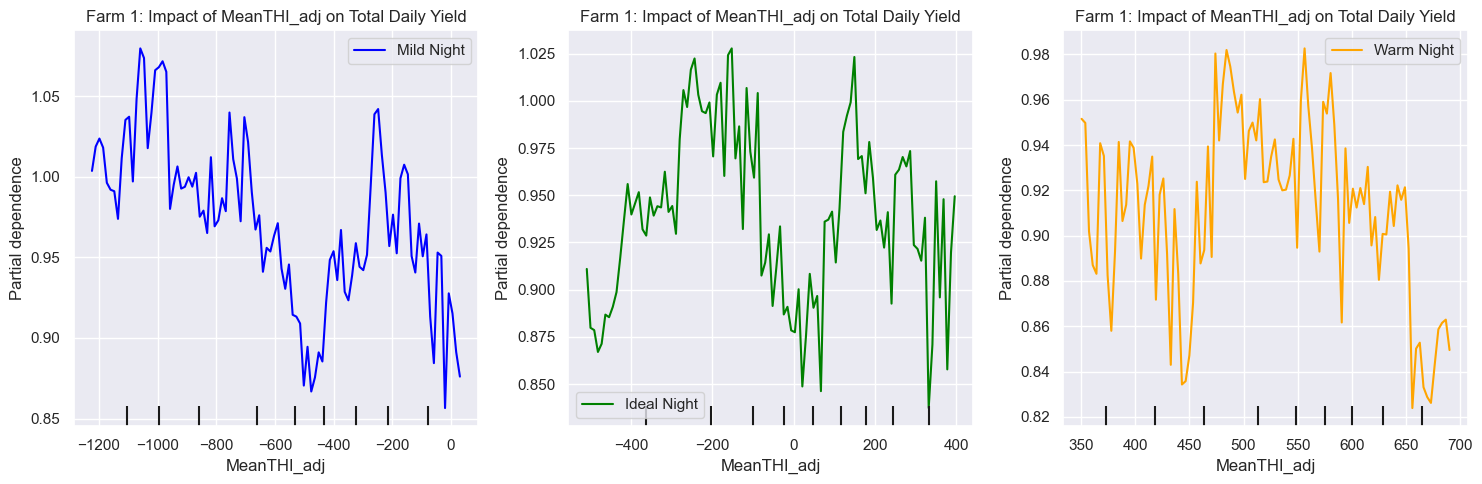

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


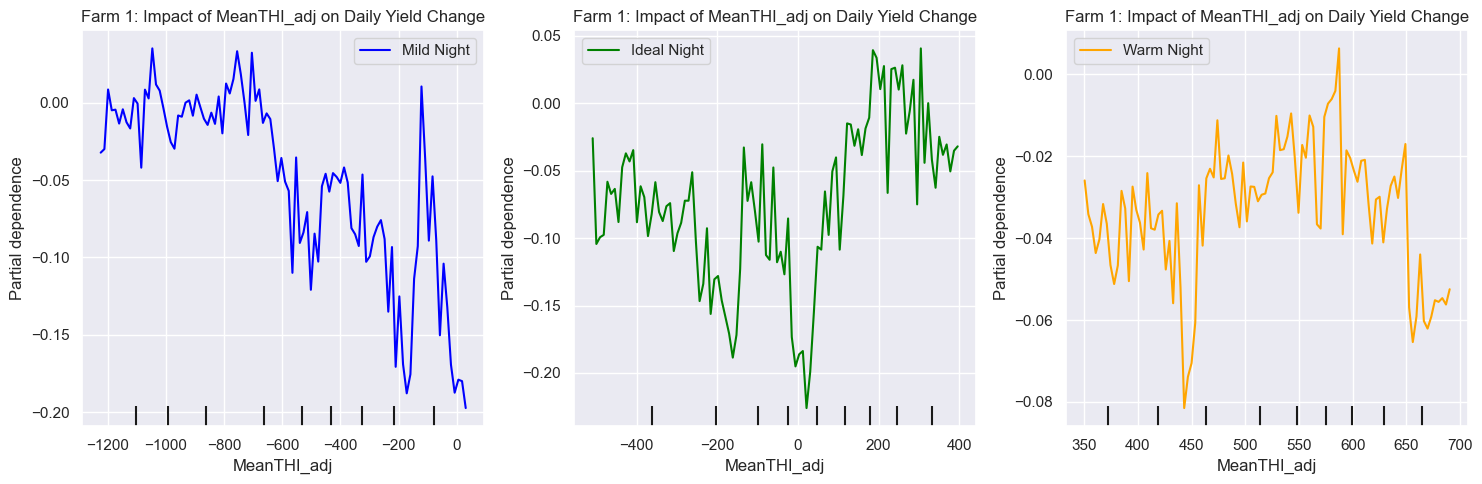

In [17]:
# Assuming 'rf_model_totyield', 'rf_model_yieldchange', 'X', 'color_map', and 'normalized_yields' are defined
features = ['MeanTemperature', 'MeanTHI_adj']
night_temp_categories = [cat for cat in normalized_yields['NightTempCategory'].unique() if cat != 'Cold']

color_map = {
    'Mild': 'blue', # cold temperatures
    'Ideal': 'green',  # Comfortable temperatures
    'Warm': 'orange',  # Temperatures where caution is needed
    'Tropical': 'red',  # Alert for high temperatures
}

# Loop over each feature
for feature in features:
    # Create a figure for the total yield of the feature
    plt.figure(figsize=(15, 5))
    for i, temp_category in enumerate(night_temp_categories):
        # Recalculate X_subset for each temp_category
        X_subset = X[normalized_yields['NightTempCategory'] == temp_category]
        
        ax = plt.subplot(1, 3, i+1)
        display = PartialDependenceDisplay.from_estimator(
            rf_model_totyield, X_subset, features=[feature], ax=ax,
            line_kw={'color': color_map[temp_category], 'label': f'{temp_category} Night'}
        )
        ax.set_title(f'Farm 1: Impact of {feature} on Total Daily Yield', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel('Change in Normalized Total Daily Yield', fontsize=12)
        ax.legend(title="Night Category")
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(15, 5))
    for i, temp_category in enumerate(night_temp_categories):
        # Recalculate X_subset for each temp_category
        X_subset = X[normalized_yields['NightTempCategory'] == temp_category]
        
        ax = plt.subplot(1, 3, i+1)
        display = PartialDependenceDisplay.from_estimator(
            rf_model_yieldchange, X_subset, features=[feature], ax=ax,
            line_kw={'color': color_map[temp_category], 'label': f'{temp_category} Night'}
        )
        ax.set_title(f'Farm 1: Impact of {feature} on Daily Yield Change', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel('Change in Normalized Daily Yield Change', fontsize=12)
        ax.legend(title="Night Category")
    plt.tight_layout()
    plt.show()